# SQLite in Python

## SQLite with Cursor

In [ ]:
conn = sqlite3.connect("jobs.db")
cursor = conn.cursor()

query = "select * from recent_grads;"
cursor.execute(query)
results = cursor.fetchall()
print(results[0:2])


query2 = "select Major from recent_grads;"
cursor.execute(query2)
majors = cursor.fetchall()
print(majors[0:2])

# a Specific Number of Results ##
five_results = cursor.fetchmany(5)

# Closing the Database Connection ##

conn = sqlite3.connect("jobs.db")
conn.close()

## SQLite with Pandas

In [10]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

conn = sqlite3.connect("factbook.db")

## Get all tables

In [ ]:
tbl_query = "PRAGMA table_info(facts);"   
schema = conn.execute(tbl_query).fetchall()

for row in schema:
    print(row)

## SELECT query

In [6]:
query = "SELECT * FROM sqlite_master WHERE type='table';"
pd.read_sql_query(query,conn)

,type,name,tbl_name,rootpage,sql
0,table,facts,facts,2,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY..."
1,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"


## Limit Results

In [7]:
query = "SELECT * FROM FACTS LIMIT 5;"
pd.read_sql_query(query,conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,created_at,updated_at
0,1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51,2015-11-01 13:19:49.461734,2015-11-01 13:19:49.461734
1,2,al,Albania,28748,27398,1350,3029278,0.30,12.92,6.58,3.30,2015-11-01 13:19:54.431082,2015-11-01 13:19:54.431082
2,3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92,2015-11-01 13:19:59.961286,2015-11-01 13:19:59.961286
3,4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.00,2015-11-01 13:20:03.659945,2015-11-01 13:20:03.659945
4,5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46,2015-11-01 13:20:08.625072,2015-11-01 13:20:08.625072


## Aggregate Functions in SELECT

In [8]:
query = "SELECT MIN(population), MAX(population), MIN(population_growth), MAX(population_growth) FROM facts;"
pd.read_sql_query(query,conn)

,MIN(population),MAX(population),MIN(population_growth),MAX(population_growth)
0,0,7256490011,0.0,4.02


## WHERE Clause

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x115acca20>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x115c09f98>]], dtype=object)

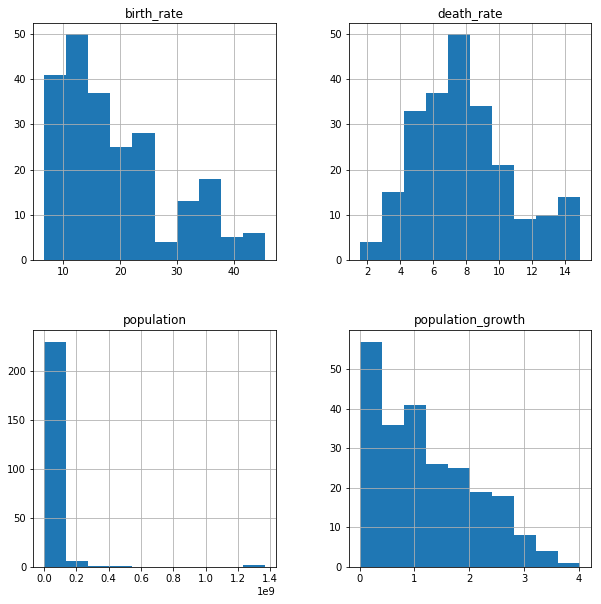

In [11]:
query = "SELECT population, population_growth, birth_rate, death_rate FROM facts WHERE population >0 AND population < 7256490011;"
df = pd.read_sql_query(query,conn)

#simple visualisation of results
df.hist(figsize=(10,10))

## Cast column Datatypes

In [ ]:
query = "SELECT name, CAST(population as Float)/CAST(area as Float) density FROM facts ORDER BY density DESC LIMIT 20"
pd.read_sql_query(query,conn)

## Helper Functions for SQLite Queries

In [ ]:
def run_command(c):
    
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

def run_query(q):
    
        with sqlite3.connect('chinook.db') as conn:
            return pd.read_sql(q, conn)

## Create Views

In [ ]:
cmd_tracks_with_genre = '''CREATE VIEW tracks_with_genre AS 
                                SELECT 
                                    t.track_id, 
                                    t.name AS track_name, 
                                    g.name AS genre 
                                FROM track t 
                                LEFT JOIN genre g ON g.genre_id = t.genre_id'''

# cmd_drop_tracks_with_genre = "DROP VIEW tracks_with_genre"

run_command(cmd_tracks_with_genre)

## Select statement

In [ ]:
qry_track_totals_by_genre = '''SELECT 
                                    tg.genre, 
                                    CAST(SUM(il.quantity) AS Float)/CAST((SELECT CAST(SUM(quantity) AS Float) FROM USA_invoice_lines) / 100 AS Float) AS percentage,
                                    SUM(il.quantity) AS tracks_sold
                                FROM USA_invoice_lines AS il 
                                LEFT JOIN tracks_with_genre tg ON tg.track_id = il.track_id 
                                GROUP BY 1 
                                ORDER BY 2 DESC 
                                LIMIT 10'''

df = run_query(qry_track_totals_by_genre)

## Select with Case statement

In [ ]:
qry_country_data = ''' SELECT 
                            country,
                            sum(count_of_customers) AS number_customers, 
                            sum(order_total) AS total_sales,
                            ROUND(sum(order_total)/sum(count_of_customers),2) AS avg_sale_per_customer,
                            ROUND(sum(order_total)/sum(count_of_orders),2) AS avg_order_value
                      FROM
                          (
                          SELECT
                                original_country,
                                count_of_customers,
                                count_of_orders,
                                order_total,
                                CASE
                                    WHEN count_of_customers = 1 THEN 0
                                    ELSE 1
                                END AS sort_order,
                                CASE
                                    WHEN count_of_customers = 1 THEN "Other"
                                    ELSE original_country
                                END AS country
                                FROM country_invoices ci
                          ) 
                    GROUP BY 1
                    ORDER BY sort_order DESC, total_sales DESC'''

run_query(qry_country_data)

## Explain Query Plan
How the query will be executed, without actually executing the query

In [ ]:
query_plan_one = conn.execute("EXPLAIN QUERY PLAN SELECT * FROM facts WHERE population > 100000 AND population_growth < 0.05;").fetchall()
print(query_plan_one)

## Query plan for multi-column queries ##

In [ ]:
conn.execute("CREATE INDEX IF NOT EXISTS pop_idx on facts(population);").fetchall()
conn.execute("CREATE INDEX IF NOT EXISTS pop_growth_idx on facts(population_growth);").fetchall()
query_plan_two = conn.execute("EXPLAIN QUERY PLAN SELECT * FROM facts WHERE population >100000 AND population_growth < 0.05;").fetchall()

print(query_plan_two)

## Covering index ##

In [ ]:
conn.execute("create index if not exists pop_pop_growth_idx on facts(population, population_growth);")
query_plan_four = conn.execute("EXPLAIN QUERY PLAN SELECT population, population_growth FROM facts WHERE population >100000 AND population_growth <0.05;").fetchall()
print(query_plan_four)

## Covering index for single column ##

In [ ]:
conn.execute("create index if not exists pop_pop_growth_idx on facts(population, population_growth);")
query_plan_five = conn.execute("EXPLAIN QUERY PLAN SELECT population FROM facts WHERE population > 1000000;").fetchall()
print(query_plan_five)

## Creating a multi-column index ##

In [ ]:
conn.execute("CREATE INDEX IF NOT EXISTS pop_pop_growth_idx ON facts(population, population_growth);").fetchall()
query_plan_three = conn.execute("EXPLAIN QUERY PLAN SELECT * FROM facts WHERE population >100000 AND population_growth < 0.05;").fetchall()
print(query_plan_three)